# AMPA synapse model

## Model overview

AMPA receptor is an ionotropic receptor of neurotransmitter `Glutamate`. After being bound by Glutamate, it opens the sodium and potassium ion channels and induce postsynaptic current.

AMPA receptor plays important role in long-term potentiation.

This synapse model describes the transmitter-activated ion channel as synaptic conductance $g_{syn}(t)$.

Our implementation is based on BrainPy framework.

In [1]:
import brainpy as bp
import numpy as np

We will implement two types of AMPA model. `AMPA 1` is a simple model with one exponential decay, and `AMPA 2` is a HH-like model.

## AMPA 1

Let's first take a look at a simple model with only one exponential decay.

Synaptic conductance $g_{syn}$ is given by:

$$g_{syn} = \bar{g}_{syn} s $$

where $\bar{g}_{syn}$ is the maximum synaptic conductance. 

The gating variable $s$ represents the fraction of open synaptical channel. It's dynamic is given by:

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k})$$

where $\tau_{decay}$ is around 2 to 5 ms.

Here we will implement the dynamics of $g_{syn}$ with a `update()` function.

The synaptic current $I_{syn}$ represents the current that passes through a synaptic channel, which is given by: 

$$I_{syn}= g_{syn} (V-E_{syn})$$

where $V$ is the membrane potential of the post-synaptic neuron (where the receptors and ion channels located in), and the reversal potential $E_{syn}$ for AMPA receptor is $0$.

We will implement synaptic delay between the pre-synaptic spike and the post-synaptic changes by using the decorator `@bp.delayed` before the `output` function.

Post-synaptic input current will be the sum of synaptic current from all channels.

In [2]:
E_SYN = 0.
TAU = 2.
G_MAX = .10

def AMPA1(g_max=G_MAX, E=E_SYN, tau_decay=TAU):    
    ST=bp.types.SynState('s')
    
    requires = dict(
        pre=bp.types.NeuState('spike'),
        post=bp.types.NeuState('V', 'input')
    )

    # dynamics of gating variable
    @bp.integrate
    def ints(s, _t):
        return - s / tau_decay

    # update of synaptic conductance
    def update(ST, _t, pre):
        s = ints(ST['s'], _t)
        if pre['spike'] > 0.:
            s += 1
        ST['s'] = s     

    # synaptic current
    @bp.delayed
    def output(ST, post):
        post['input'] += - g_max * ST['s'] * (post['V'] - E)

    return bp.SynType(name='AMPA1_synapse', ST=ST, requires=requires, steps=(update, output), mode='scalar')


### Simulation

A synapse model include two neuron models and a synapse, we will import the LIF neuron model first.

In [3]:
from bpmodels.neurons import get_LIF

Let's define a function to simulate the progress of pre->ampa->post.

We'll apply the current to the synapse (inject action potential to the pre-synaptic neuron by give input to `'pre.sp'`)

In [4]:
import matplotlib.pyplot as plt

def run_syn(define, I_ext, duration, sim_pos = 'pre.spike'):
    '''
    Run simulation with synapse model.
    
    Args:
        define (SynType): synapse model.
        I_ext (NPArray): external current.
        duration (float): duration of the external current.
        sim_pos (string): position that is given the exernal current, default = 'pre.spike'.
    '''
    LIF = get_LIF(V_rest=-65., V_reset=-65., V_th=-55.)
    pre = bp.NeuGroup(LIF, 1, monitors=['spike', 'V'])
    pre.ST['V'] = -65.
    post = bp.NeuGroup(LIF, 1, monitors=['V'])
    post.ST['V'] = -65.
    syn = bp.SynConn(model=define, pre_group=pre, post_group=post, 
                      conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.5)

    # set syn behaviour
    syn.set_schedule(['input', 'update', 'output', 'monitor'])

    # build network connection (pre-> syn-> post)
    net = bp.Network(pre, syn, post)
        
    # run simulation
    net.run(duration, inputs=(syn, sim_pos, I_ext, '='), report=False)

    # visualization
    if sim_pos == 'pre.input':
        n_plots = 3
    else:
        n_plots = 2
    
    fig, gs = bp.visualize.get_figure(n_plots, 1, 4, 9)
    
    ts = net.ts
    
    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, syn.mon.s[:, 0], label='gating variable')
    if sim_pos == 'pre.input':
        plt.plot(ts, pre.mon.spike[:, 0], label='pre spike')
    else:
        plt.plot(ts, I_ext, label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, post.mon.V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')
    
    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, pre.mon.V[:, 0])
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre-synaptic potential')

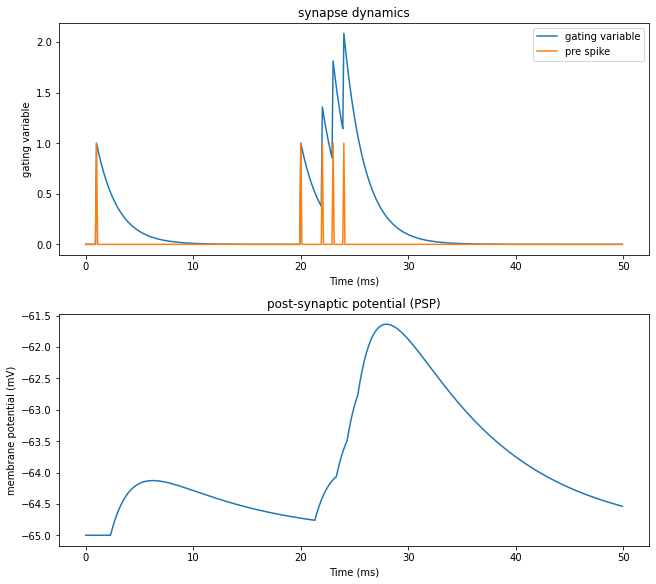

In [5]:
# get input current
spike_ts = [1, 20, 22, 23, 24]
duration = 50
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_syn(define = AMPA1(), I_ext = spike_I, duration = duration)

## AMPA 2

We can also make a model which has the flavor of a Hodgkin-Huxley channel.

The synaptic current is given by:

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

where the dynamics of gating variable $s$ is given by:

$$ \frac{ds}{dt} =\alpha[T](1-s)-\beta s $$

where $\alpha$ and $\beta$ are the binding constant and unbinding constant, respectively. $[T]$ indicates the concentration of neurotransmitter. When a presynaptic neuron fire, $[T]=[T]+0.5$, lasting for 0.5 ms.

In [6]:
def AMPA2(g_max=0.42, E=E_SYN, alpha=0.98, beta=0.18, T=0.5, T_duration=0.5):
    ST=bp.types.SynState('s', t_last_spike=-1e7)
    
    requires = {
        'pre': bp.types.NeuState('spike'),
        'post': bp.types.NeuState('V', 'input')
    }

    @bp.integrate
    def int_s(s, t, TT):
        return alpha * TT * (1 - s) - beta * s

    def update(ST, _t, pre, post):
        if pre['spike'] > 0.:
            ST['t_last_spike'] = _t
        TT = ((_t - ST['t_last_spike']) < T_duration) * T
        s = np.clip(int_s(ST['s'], _t, TT), 0., 1.)
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        post['input'] += - g_max * ST['s'] * (post['V'] - E)

    return bp.SynType(name='AMPA2_synapse', ST=ST, requires=requires, steps=(update, output), mode = 'scalar')

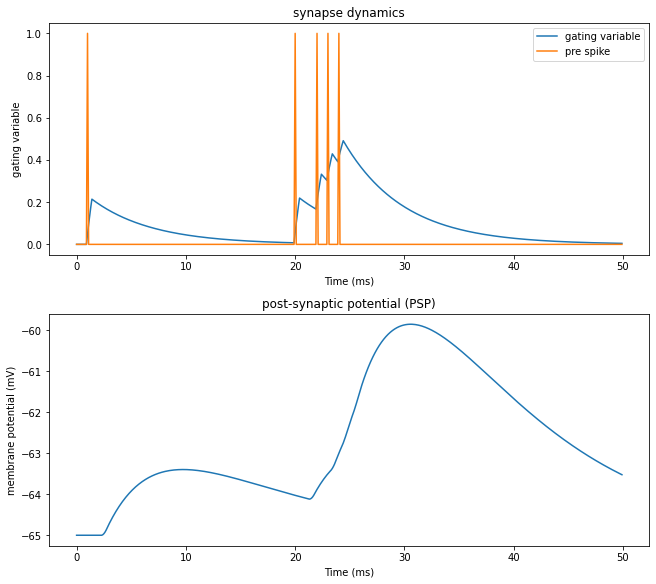

In [7]:
run_syn(define = AMPA2(), I_ext = spike_I, duration = duration)

The graphs show similar dynamics of the gating variable between the two models. Since there is only one exponential decay of the AMPA1 model, it decays quickly after pre-synatical spikes. While the dynamic of AMPA2 model is modulated by two constants, it acts smoother.

### Stimulating pre-synaptic neuron

Let's see the effect of stimulating the presynaptic neuron on the postsynaptic neuron.

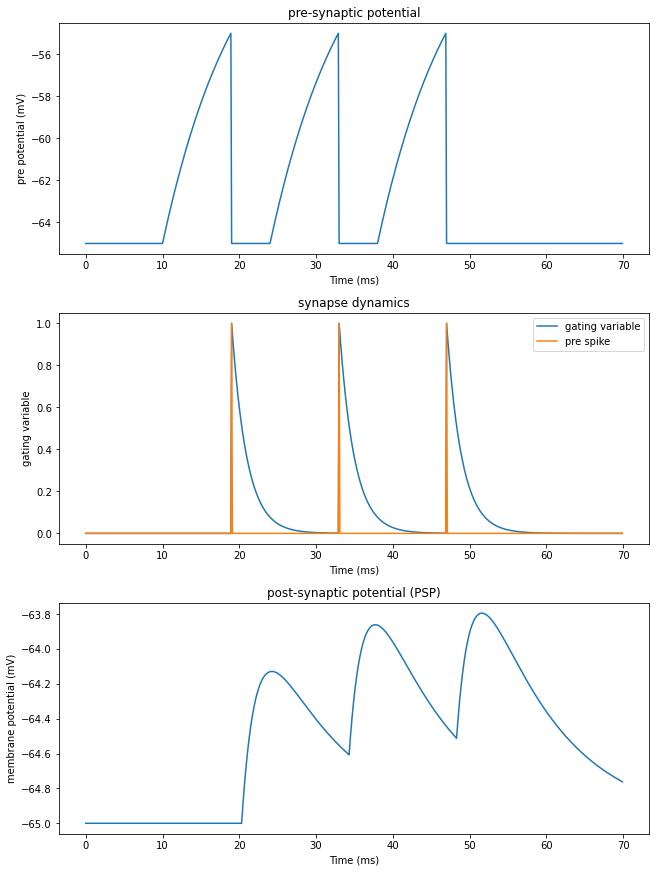

In [8]:
# step current parameters
amplitude = 16.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 20. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_syn(define = AMPA1(), I_ext = step_I, duration = duration, sim_pos = 'pre.input')

## Vector based Implementation

Let's improve our codes to speed up the simulations. In vector-based mode, the `ST` would be a vector.

Again, we will implement the two kinds of models and compare there results.

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}) $$

In [9]:
def AMPA1_vector(g_max=0.10, E=0., tau_decay=2.0):
    @bp.integrate
    def ints(s, t):
        return - s / tau_decay

    ST = bp.types.SynState('s', 'g')
    
    requires = dict(
        pre = bp.types.NeuState('spike'),
        post = bp.types.NeuState('V', 'input'),
        pre2syn = bp.types.ListConn(),
        post_slice_syn = bp.types.Array(dim=2)
    )

    def update(ST, _t, pre, pre2syn):
        # exponential decay
        s = ints(ST['s'], _t)

        # dynamics of transmitter-activated ion channels
        spikeike_idx = np.where(pre['spike'] > 0.)[0]
        for i in spikeike_idx:
            syn_idx = pre2syn[i]
            s[syn_idx] += 1.

        # update values
        ST['s'] = s
        ST['g'] = g_max * s

    @bp.delayed
    def output(ST, post, post_slice_syn):
        num_post = post_slice_syn.shape[0]
        post_cond = np.zeros(num_post, dtype=np.float_)
        for post_id in range(num_post):
            pos = post_slice_syn[post_id]
            post_cond[post_id] = np.sum(ST['g'][pos[0]: pos[1]])
        post['input'] -= post_cond * (post['V'] - E)

    return bp.SynType(name='AMPA1',
                      ST = ST,
                      requires=requires,
                      steps=(update, output),
                      mode = 'vector')

In [10]:
def AMPA2_vector(g_max=0.42, E=0., alpha=0.98, beta=0.18, T=0.5, T_duration=0.5):
    @bp.integrate
    def int_s(s, _t, TT):
        return alpha * TT * (1 - s) - beta * s

    ST=bp.types.SynState('s', 'g', t_last_spike=-1e7)
    
    requires = dict(
        pre=bp.types.NeuState('spike'),
        post=bp.types.NeuState('V', 'input'),
        pre2syn=bp.types.ListConn(),
        post_slice_syn=bp.types.Array(dim=2)
    )

    def update(ST, _t, pre, pre2syn):
        for i in np.where(pre['spike'] > 0.)[0]:
            syn_idx = pre2syn[i]
            ST['t_last_spike'][syn_idx] = _t
        TT = ((_t - ST['t_last_spike']) < T_duration) * T
        s = np.clip(int_s(ST['s'], _t, TT), 0., 1.)
        ST['s'] = s
        ST['g'] = g_max * s

    @bp.delayed
    def output(ST, post, post_slice_syn):
        num_post = post_slice_syn.shape[0]
        post_cond = np.zeros(num_post, dtype=np.float_)
        for post_id in range(num_post):
            pos = post_slice_syn[post_id]
            post_cond[post_id] = np.sum(ST['g'][pos[0]: pos[1]])
        post['input'] -= post_cond * (post['V'] - E)

    return bp.SynType(name='AMPA',
                      ST=ST,
                      requires=requires,
                      steps=(update, output),
                      mode = 'vector')

### Simulation

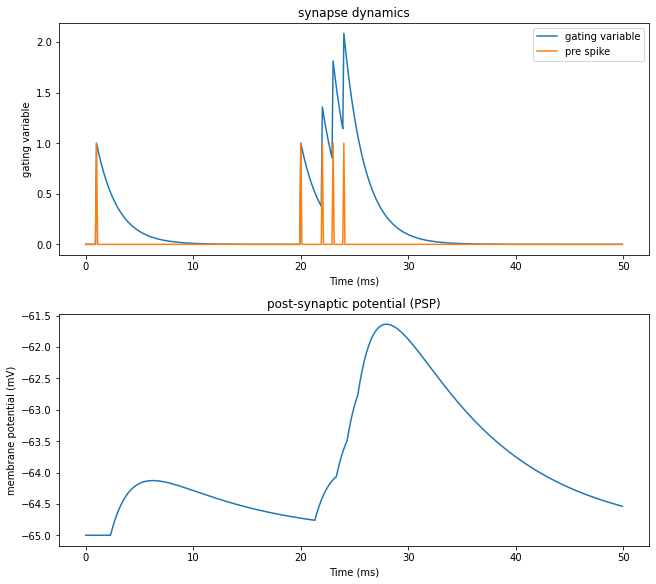

In [11]:
# get input current
spike_ts = [1, 20, 22, 23, 24]
duration = 50
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_syn(define = AMPA1_vector(), I_ext = spike_I, duration = duration)

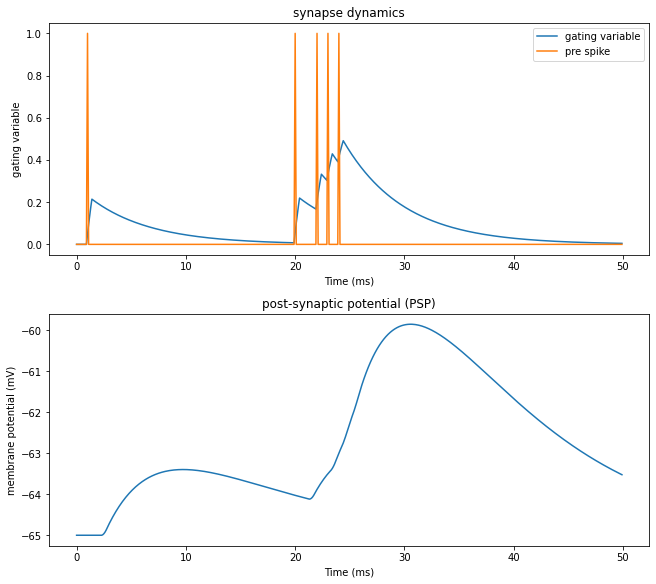

In [12]:
run_syn(define = AMPA2_vector(), I_ext = spike_I, duration = duration)

# NMDA synapse model

## Model overview

NMDA receptor is other receptor of neurotransmitter `Glutamate`.

NMDA-receptor controlled channels exhibit a rich repertoire of dynamic behavior because their state is not only controlled by the presence or absence of glutamate, but also by the membrane potential. 

At resting potential, the NMDA channel is blocked by a common extracellular ion, ${\rm Mg}^{2+}$, even if glutamate is present. If the membrane is depolarized beyond −50 mV, the ${\rm Mg}^{2+}$-block is removed, the channel opens when glutamate binds to the receptor and, thereafter, stays open for 10 – 100 milliseconds.

A simple model of the voltage dependence of NMDA-receptor controlled channels is

$$ g(t) = \bar{g}_{syn} \cdot g_{\infty}  s $$

where

$$ g_{\infty}(V,[{Mg}^{2+}]_{o}) =(1+{e}^{-\alpha V} \cdot \frac{[{Mg}^{2+}]_{o} } {\beta})^{-1}  $$

Dynamics of $s$ is given by:

$$ \frac{d s_{j}(t)}{dt} =-\frac{s_{j}(t)}{\tau_{decay}}+a x_{j}(t)(1-s_{j}(t))  $$

$$ \frac{d x_{j}(t)}{dt} =-\frac{x_{j}(t)}{\tau_{rise}}+
\sum_{k} \delta(t-t_{j}^{k})  $$

where the decay time of NMDA currents is taken to be $\tau_{decay}=100 ms$,
$a= 0.5 ms^{-1}$, and$\tau_{rise} =2 ms$ (Hestrin et al., 1990; Spruston et al., 1995).

Again, the synaptic current is:

$$ I_{syn}= g(t) \cdot (V-E_{syn})$$

In [13]:
def NMDA(g_max=1.5, E=0, alpha=0.062, beta=3.57, cc_Mg=1.2, tau_decay=100., a=0.5, tau_rise=2.):
    ST=bp.types.SynState('x', 's')
    
    requires = dict(
        pre=bp.types.NeuState('spike'),
        post=bp.types.NeuState('V', 'input')
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)

    def update(ST, _t, pre):
        x = int_x(ST['x'], _t)
        x += pre['spike']
        s = int_s(ST['s'], _t, x)
        ST['x'] = x
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        g = g_max * ST['s'] * (post['V'] - E)
        g_inf = 1 + cc_Mg / beta * np.exp(-alpha * post['V'])
        post['input'] -= g / g_inf

    return bp.SynType(name='NMDA',
                      ST = ST,
                      requires=requires,
                      steps=(update, output),
                      mode = 'scalar')

### simulation

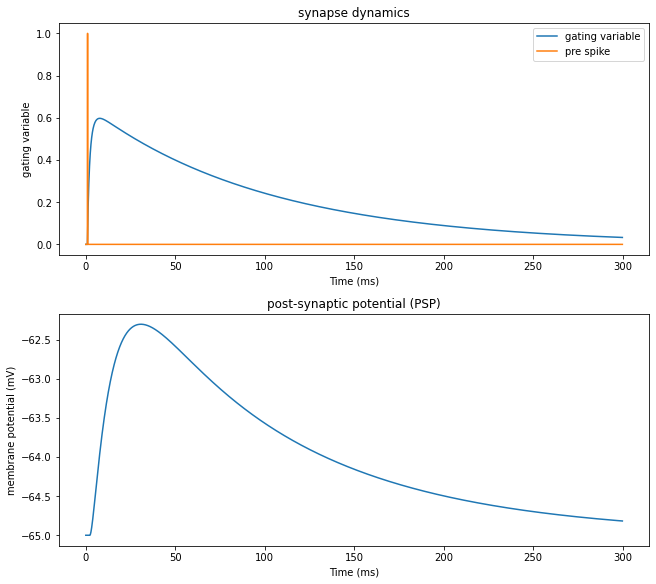

In [14]:
# get input current
spike_ts = [1]
duration = 300
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_syn(define = NMDA(), I_ext = spike_I, duration = duration)

### Pre-synaptic stimulation

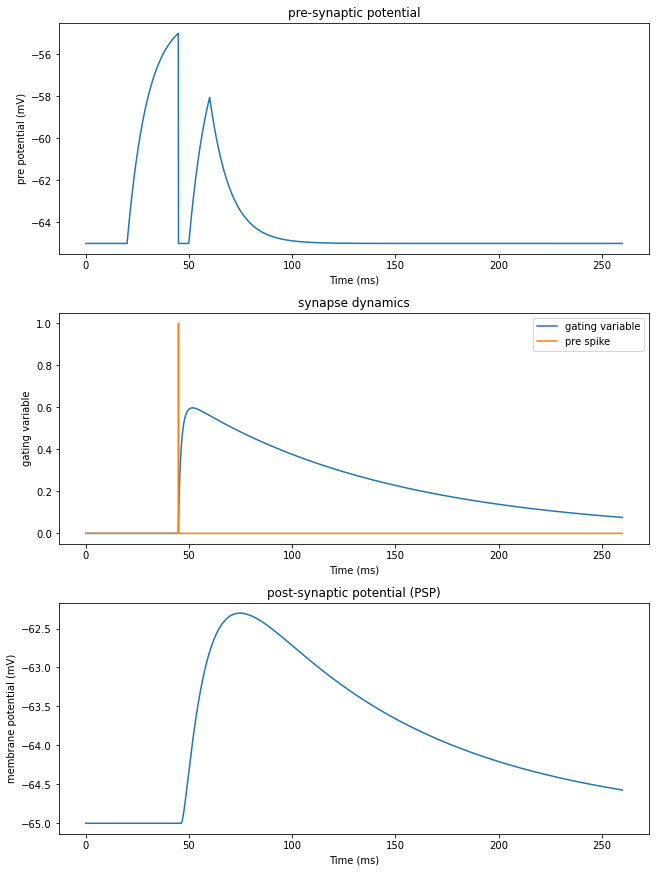

In [15]:
# step current parameters
amplitude = 10.9  # step current amplitude
stim_start = 20. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_syn(define = NMDA(), I_ext = step_I, duration = duration, sim_pos = 'pre.input')

### NMDA vector-based implementation

In [16]:
def NMDA_vector(g_max=0.15, E=0, alpha=0.062, beta=3.75, cc_Mg=1.2, tau_decay=100., a=0.5, tau_rise=2.):
    ST=bp.types.SynState('x', 's', 'g')
    
    requires = dict(
        pre=bp.types.NeuState('spike'),
        post=bp.types.NeuState('V', 'input'),
        pre2syn=bp.types.ListConn(),
        post_slice_syn=bp.types.Array(dim=2)
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)

    def update(ST, _t, pre, pre2syn):
        for pre_id in np.where(pre['spike'] > 0.)[0]:
            syn_ids = pre2syn[pre_id]
            ST['x'][syn_ids] += 1.
        x = int_x(ST['x'], _t)
        s = int_s(ST['s'], _t, x)
        ST['x'] = x
        ST['s'] = s
        ST['g'] = g_max * s

    @bp.delayed
    def output(ST, post, post_slice_syn):
        g_inf = 1 + cc_Mg / beta * np.exp(-alpha * post['V'])
        
        num_post = post_slice_syn.shape[0]
        post_cond = np.zeros(num_post, dtype=np.float_)
        for post_id in range(num_post):
            pos = post_slice_syn[post_id]
            post_cond[post_id] = np.sum(ST['g'][pos[0]: pos[1]])
        post['input'] -= post_cond * (post['V'] - E) / g_inf

    return bp.SynType(name='NMDA',
                      ST = ST,
                      requires=requires,
                      steps=(update, output),
                      mode = 'vector')

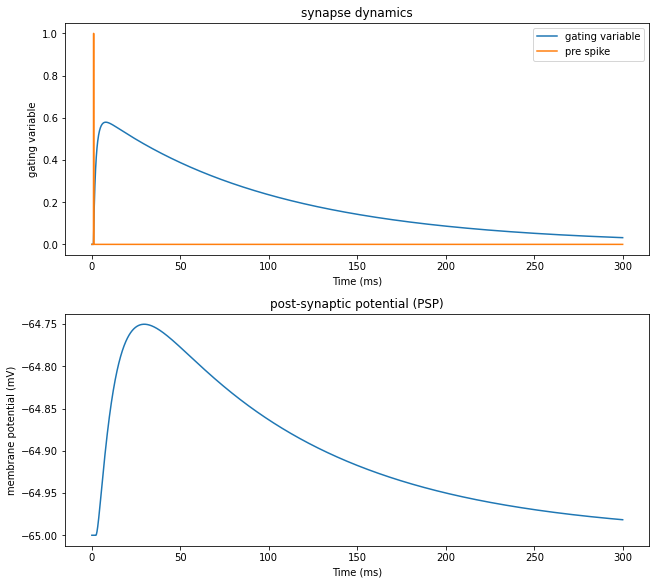

In [17]:
# get input current
spike_ts = [1]
duration = 300
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_syn(define = NMDA_vector(), I_ext = spike_I, duration = duration)

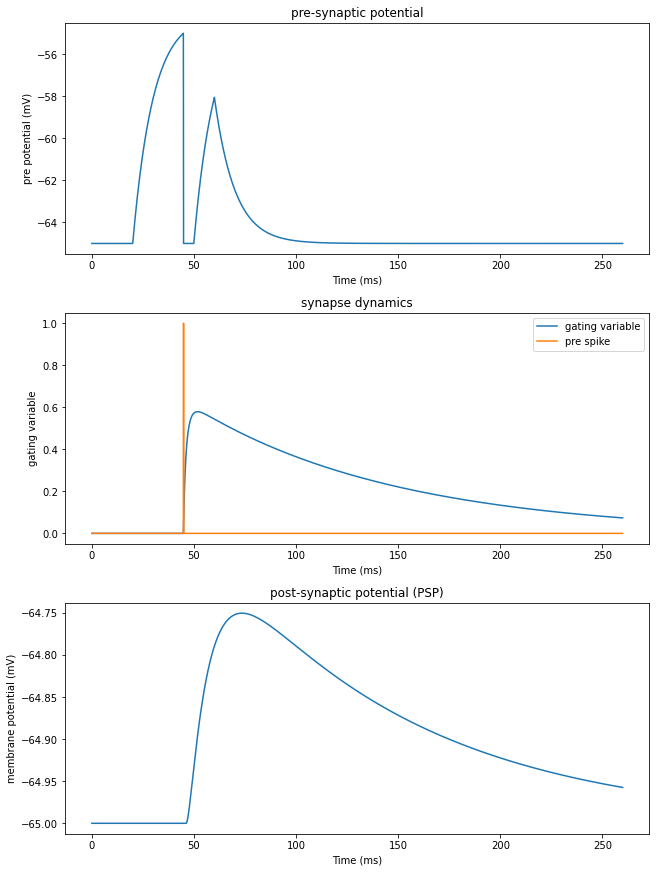

In [18]:
# step current parameters
amplitude = 10.9  # step current amplitude
stim_start = 20. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_syn(define = NMDA_vector(), I_ext = step_I, duration = duration, sim_pos = 'pre.input')

## Excitatory synapses: AMPA and NMDA

AMPA and NMDA are two receptors of Glutamate, let's see the difference of the two receptors after the coming of Glutamate.

In [19]:
def run_glu_single(nmda_model, ampa_model, I_ext, duration, sim_pos = 'pre.spike'):
    LIF = get_LIF(V_rest=-65., V_reset=-65., V_th=-55.)
    n_pre = bp.NeuGroup(LIF, 1, monitors=['spike', 'V'])
    n_pre.ST['V'] = -65.
    n_post = bp.NeuGroup(LIF, 1, monitors=['V'])
    n_post.ST['V'] = -65.
    nmda = bp.SynConn(model=nmda_model, pre_group=n_pre, post_group=n_post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)
    
    a_pre = bp.NeuGroup(LIF, 1, monitors=['spike', 'V'])
    a_pre.ST['V'] = -65.
    a_post = bp.NeuGroup(LIF, 1, monitors=['V'])
    a_post.ST['V'] = -65.
    ampa = bp.SynConn(model=ampa_model, pre_group=a_pre, post_group=a_post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)

    # set synapse behaviour
    nmda.runner.set_schedule(['input', 'update', 'output', 'monitor'])
    ampa.runner.set_schedule(['input', 'update', 'output', 'monitor'])
    
    # build network connection
    net_nmda = bp.Network(n_pre, nmda, n_post)
    net_ampa = bp.Network(a_pre, ampa, a_post)

    # run simulation
    net_nmda.run(duration, inputs=(nmda, sim_pos, I_ext, '='), report=False)
    net_ampa.run(duration, inputs=(ampa, sim_pos, I_ext, '='), report=False)

    # visualization
    if sim_pos == 'pre.input':
        n_plots = 2
    else:
        n_plots = 1

    fig, gs = bp.visualize.get_figure(n_plots, 1, 4, 9)

    ts = net_nmda.ts

    # synapse
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, nmda.mon.s[:, 0], 'b', label='NMDA')
    plt.plot(ts, ampa.mon.s[:, 0], 'g', label='AMPA')
    if sim_pos == 'pre.input':
        plt.plot(ts, n_pre.mon.spike[:, 0], 'r', label='pre spike')
        #plt.plot(ts, a_pre.mon.spike[:, 0], 'r', label='pre spike (AMPA)')
    else:
        pass
        #plt.plot(ts, I_ext, 'r', label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()   

    if n_plots == 2:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, n_pre.mon.V[:, 0])
        plt.plot(ts, a_pre.mon.V[:, 0], 'b')
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre potential')

### Single spike

Let's run simulation to see the dynamics of gating variables after a single pre-synaptic spike at $t=0$. 

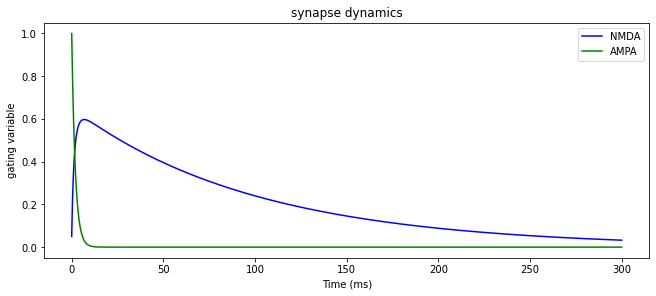

In [20]:
# get input current
spike_ts = [0]
duration = 300.
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_glu_single(nmda_model = NMDA(), ampa_model = AMPA1(), I_ext = spike_I, duration = duration)

### Pre-synaptic stimulation

Let's inject a step current to the pre-synaptic neuron and see the responses of the NMDA and AMPA synapses.

In [21]:
# step current parameters
amplitude = 12.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

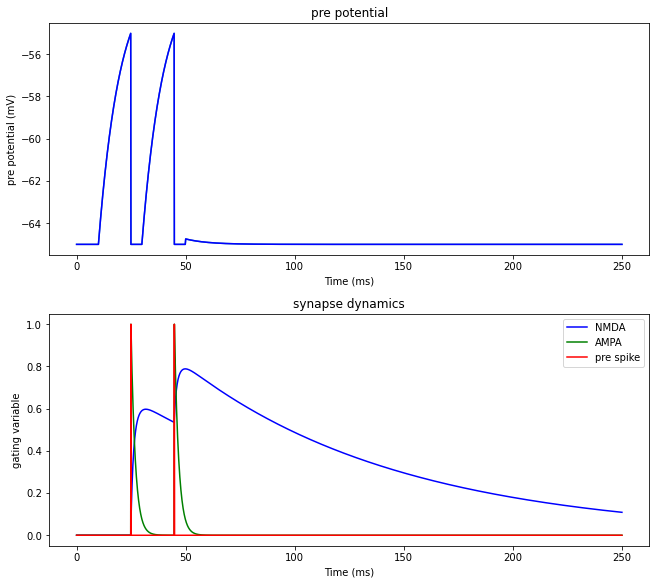

In [22]:
run_glu_single(nmda_model = NMDA(), ampa_model = AMPA1(), I_ext = step_I, duration = duration, sim_pos = 'pre.input')

Our simulation results correspond to the biological data that AMPA receptors decay rapidly and NMDA receptors often decay much slower. 

**References:**

[1] Brunel N, Wang X J. Effects of neuromodulation in a 
               cortical network model of object working memory dominated 
               by recurrent inhibition[J]. 
               Journal of computational neuroscience, 2001, 11(1): 63-85.
 
[2] Gerstner, Wulfram, et al. Neuronal dynamics: From single 
               neurons to networks and models of cognition. Cambridge 
               University Press, 2014.